![Redis](https://redis.io/wp-content/uploads/2024/04/Logotype.svg?auto=webp&quality=85,75&width=120)
# Using smaller vector types

With the [Redis 7.4 release](https://redis.io/blog/announcing-redis-community-edition-and-redis-stack-74/) there is now support for bfloat16 and float16 data types in the vector store. And with the release of [RedisVL 0.4.0](https://github.com/redis/redis-vl-python/tree/0.4.0) we've added support for integer vector types int8 and uint8 as well.


This tutorial will walk through how you can convert data stored in an existing index from the default float32 vectors to float16 or 8 bit integers.

## Version requirements for float16 and bfloat16 datatypes

- redisvl >= 0.3.4
- redis >= 7.4.0


## Version requirements for int8 and uint8 datatypes

- redisvl >= 0.4.0
- redis >= 7.9.226


## Let's Begin!
<a href="https://colab.research.google.com/github/redis-developer/redis-ai-resources/blob/main/python-recipes/vector-search/03_dtype_support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare data
In these examples we will load a list of movie objects with the following attributes: title, rating, description, and genre.

For the vector part of our vector search we will embed the description so that users can search for movies that best match what they're looking for.

If you are running this notebook locally, FYI you may not need to perform this step at all.

In [ ]:
# NBVAL_SKIP
!git clone https://github.com/redis-developer/redis-ai-resources.git temp_repo
!mv temp_repo/python-recipes/vector-search/resources .
!rm -rf temp_repo

'\n# NBVAL_SKIP\n!git clone https://github.com/redis-developer/redis-ai-resources.git temp_repo\n!mv temp_repo/python-recipes/vector-search/resources .\n!rm -rf temp_repo\n'

## Packages

Let's start with float16 and bfloat16 support

In [2]:
%pip install -q "redis>=5.0.8" "redisvl>=0.4.1" numpy sentence-transformers


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import redisvl
assert redisvl.__version__ >= '0.3.4'

## Run Redis Stack

For this tutorial you will need a running instance of Redis if you don't already have one.

#### For Colab
Use the shell script below to download, extract, and install [Redis Stack](https://redis.io/docs/getting-started/install-stack/) directly from the Redis package archive.

In [ ]:
# NBVAL_SKIP
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

'\n# NBVAL_SKIP\n%%sh\ncurl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg\necho "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list\nsudo apt-get update  > /dev/null 2>&1\nsudo apt-get install redis-stack-server  > /dev/null 2>&1\nredis-stack-server --daemonize yes\n'

#### For Alternative Environments
There are many ways to get the necessary redis-stack instance running
1. On cloud, deploy a [FREE instance of Redis in the cloud](https://redis.com/try-free/). Or, if you have your
own version of Redis Enterprise running, that works too!
2. Per OS, [see the docs](https://redis.io/docs/latest/operate/oss_and_stack/install/install-stack/)
3. With docker: `docker run -d --name redis-stack-server -p 6379:6379 redis/redis-stack-server:latest`

## Check Redis Version

For this tutorial it's important to validate that your redis instance meets the version requirements you can do this through a number of the UI's available or check the docker tag your using itself.

### Redis cloud
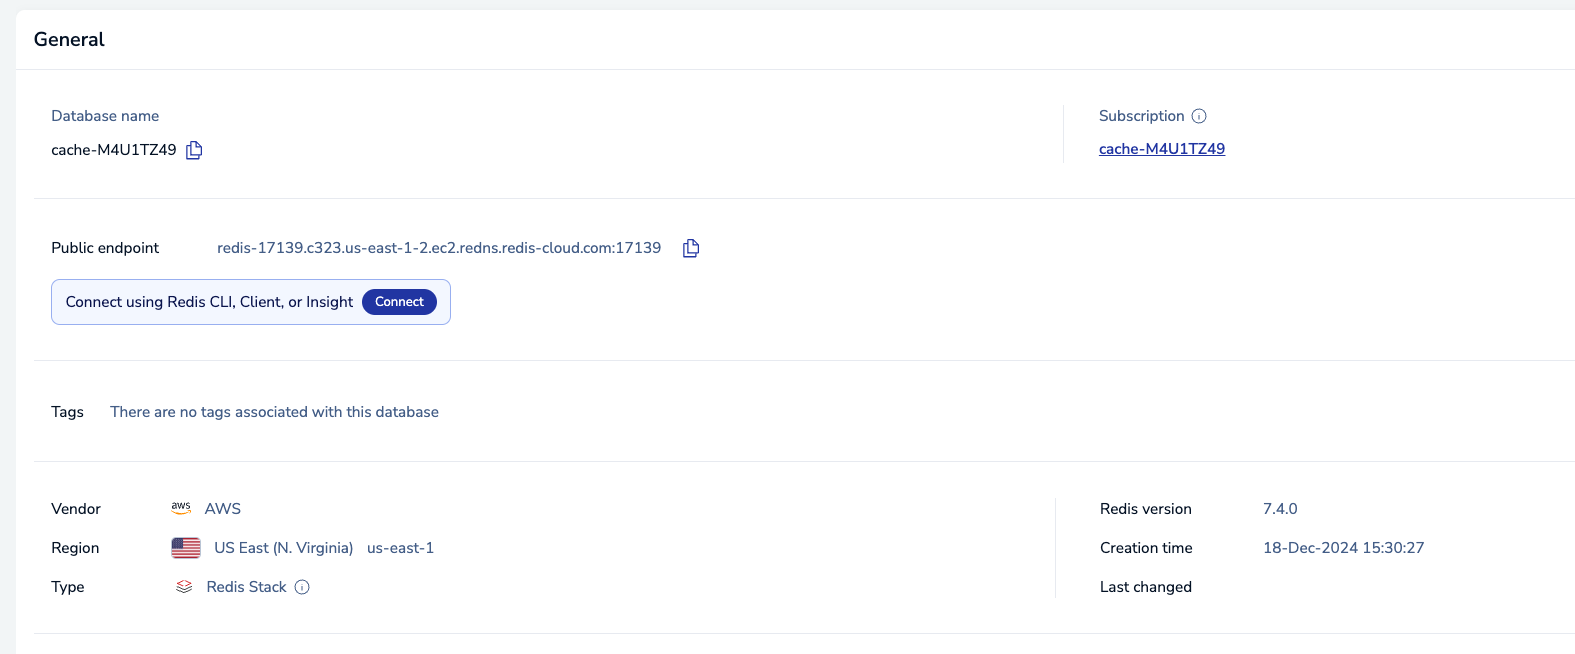

### Redis insight
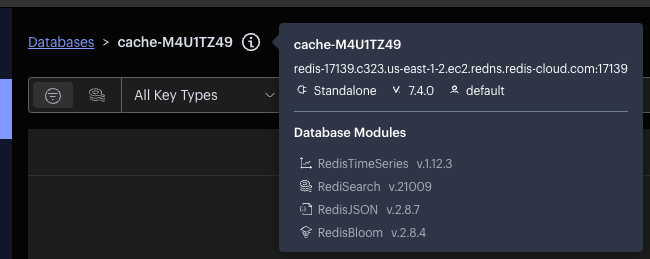

### Docker

See [docker tags](https://hub.docker.com/_/redis/tags)

## Connect to index by defining REDIS_URL

In [5]:
import os

# Replace values below with your own if using Redis Cloud instance
REDIS_HOST = os.getenv("REDIS_HOST", "localhost") # ex: "redis-18374.c253.us-central1-1.gce.cloud.redislabs.com"
REDIS_PORT = os.getenv("REDIS_PORT", "6379")      # ex: 18374
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD", "")  # ex: "1TNxTEdYRDgIDKM2gDfasupCADXXXX"

# If SSL is enabled on the endpoint, use rediss:// as the URL prefix
REDIS_URL = f"redis://:{REDIS_PASSWORD}@{REDIS_HOST}:{REDIS_PORT}"

In [6]:
from redis import Redis

client = Redis.from_url(REDIS_URL)
client.ping()

True

# Example setup

If you already have an index populated you can skip this setup but for this tutorial we will create a float32 based index to show how to convert.

In [7]:
import json

# load raw data
with open("resources/movies.json", 'r') as file:
    movies = json.load(file)

## Create initial index

In [8]:
from redisvl.schema import IndexSchema
from redisvl.index import SearchIndex

index_name = "movies"

schema = IndexSchema.from_dict({
  "index": {
    "name": index_name,
    "prefix": index_name,
  },
  "fields": [
    {
        "name": "title",
        "type": "text",
    },
    {
        "name": "description",
        "type": "text",
    },
    {
        "name": "genre",
        "type": "tag",
        "attrs": {
            "sortable": True
        }
    },
    {
        "name": "rating",
        "type": "numeric",
        "attrs": {
            "sortable": True
        }
    },
    {
        "name": "vector",
        "type": "vector",
        "attrs": {
            "dims": 384,
            "distance_metric": "cosine",
            "algorithm": "hnsw",
            "datatype": "float32"
        }
    }
  ]
})


index = SearchIndex(schema, client)
index.create(overwrite=True, drop=True)

16:04:57 redisvl.index.index INFO   Index already exists, overwriting.


# Embed movie description vectors

In [9]:
from redisvl.utils.vectorize import HFTextVectorizer

# load a model to embed our movie descriptions, specifying the dtype we want to use
hf = HFTextVectorizer(model="sentence-transformers/all-MiniLM-L6-v2", dtype="float32")

embeddings_32 = hf.embed_many([movie["description"] for movie in movies], as_buffer=True)

/Users/justin.cechmanek/.pyenv/versions/redis-ai-res/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
embeddings_32[0]

b'\x8df|=*a\n;-\x92\xb7;3\xcb~\xbd`e\xce\xbb\xca\x16J==\xa7?=\xefv\x95<f\xfa\x06\xbe\x14Y\xcf=/\x07p=7\xdb\r\xbd\x98\xf2H\xbdne\xc6<@\xdfa=q8\x16\xbc\xf8\xd3\x13<;\xaa\x1c=\x05\xef\x89<\xba\xb0-<\x9b\xb2\x9f\xbcU\x0b\xc3\xbd\x9bNR=ql\xf7\xbcN>\x17\xbe\x18\x0b\x05\xb99u\xbf<\xb5\xe3b\xba\xd5\xa6\xa8\xbd~\xdc\xec\xbcPc%=\xc1\xe7r\xbb\x19OG=>(\x85=c@\xa2\xbc1Z\xd0\xbd>%K\xbd\xba\xed\x94\xbc\\\xddH=\xa6&F<\xd2*\xec<\x8f\xd8\x8d\xbd\xb8Z\x98<\r\xa3\xa3=*g3\xbd#\xcd\xbd\xbd\xde$\xf7;\xfd\xf4z=\xfc\xb4\x8c=\x8b\x0e\xc6\xbdfI\x90\xbdP\x16\xbd;x\xe7\x0c\xbd\x0e3\xc9\xbcj\xf8\xbb\xbc\xba&u\xbb4\x8f\xca<\x01\x80J=\x14\xaf*=\x84OU\xbd\xd1\xf0\x95\xbc\x1c\x02\x19=*\xf4K<\xca\xc2\t=B\x83\xac=\x9a\xd7\xb8\xbd\xf1\xb5\x9c\xbd>\x85\x18=\xa4d&=\x1f3\xf8<\xd8\xf7\x88<5v\xf2\xbb)=[\xbd@\xac\xee\xbb5:A\xbd\xd9d\x19\xbd/d\xf2\xbb4\xbax;\xeb;O<\xe21,\xbc\xee\xae\xae=}\x00-\xbc\x1e\x06\xae\xbdo\xd6\x1a=\xc4\xbf\xcd=\x1b\x150=\xd6\xf1\x9d\xbc\xb6GK=\xb0\xb8 =\xae\xf1I\xbd7e\x9e\xbb\x96\x8b\xf7:\x89\xf8\x1c=\x9

In [11]:
movie_data = [
    {
        **movie,
        "vector": embeddings_32[i]
    } for i, movie in enumerate(movies)
]

In [12]:
movie_data[0]

{'title': 'Explosive Pursuit',
 'genre': 'action',
 'rating': 7,
 'description': 'A daring cop chases a notorious criminal across the city in a high-stakes game of cat and mouse.',
 'vector': b'\x8df|=*a\n;-\x92\xb7;3\xcb~\xbd`e\xce\xbb\xca\x16J==\xa7?=\xefv\x95<f\xfa\x06\xbe\x14Y\xcf=/\x07p=7\xdb\r\xbd\x98\xf2H\xbdne\xc6<@\xdfa=q8\x16\xbc\xf8\xd3\x13<;\xaa\x1c=\x05\xef\x89<\xba\xb0-<\x9b\xb2\x9f\xbcU\x0b\xc3\xbd\x9bNR=ql\xf7\xbcN>\x17\xbe\x18\x0b\x05\xb99u\xbf<\xb5\xe3b\xba\xd5\xa6\xa8\xbd~\xdc\xec\xbcPc%=\xc1\xe7r\xbb\x19OG=>(\x85=c@\xa2\xbc1Z\xd0\xbd>%K\xbd\xba\xed\x94\xbc\\\xddH=\xa6&F<\xd2*\xec<\x8f\xd8\x8d\xbd\xb8Z\x98<\r\xa3\xa3=*g3\xbd#\xcd\xbd\xbd\xde$\xf7;\xfd\xf4z=\xfc\xb4\x8c=\x8b\x0e\xc6\xbdfI\x90\xbdP\x16\xbd;x\xe7\x0c\xbd\x0e3\xc9\xbcj\xf8\xbb\xbc\xba&u\xbb4\x8f\xca<\x01\x80J=\x14\xaf*=\x84OU\xbd\xd1\xf0\x95\xbc\x1c\x02\x19=*\xf4K<\xca\xc2\t=B\x83\xac=\x9a\xd7\xb8\xbd\xf1\xb5\x9c\xbd>\x85\x18=\xa4d&=\x1f3\xf8<\xd8\xf7\x88<5v\xf2\xbb)=[\xbd@\xac\xee\xbb5:A\xbd\xd9d\x19\xb

# Populate the index

In [13]:
keys = index.load(movie_data)
keys

['movies:01JNPYPXESW7HK5NXNGSPW8Z6F',
 'movies:01JNPYPXESSMY8A6NX2D5MRFKP',
 'movies:01JNPYPXES9HSWPMX81EQ92SYN',
 'movies:01JNPYPXET2QQF4B8A9GHYM7J3',
 'movies:01JNPYPXETCMJMS30VPE78HWNZ',
 'movies:01JNPYPXETG31JCKC0JM9GQHGN',
 'movies:01JNPYPXETYA2AYQB5EGJYKES7',
 'movies:01JNPYPXETXJV8PWSXG9D679A5',
 'movies:01JNPYPXETGK5ZFDD60QQ6H4BF',
 'movies:01JNPYPXET8FX74WBA7WJ4ZH89',
 'movies:01JNPYPXETHWDV3NT5H7DA43NR',
 'movies:01JNPYPXET13M9P6AW9PEF996S',
 'movies:01JNPYPXETMBRRE0T8K738WG9Q',
 'movies:01JNPYPXETDC4GHKFS6F4KD6YT',
 'movies:01JNPYPXET72R3J7FQKZ6K59G6',
 'movies:01JNPYPXET30F33K43Z850Y8SS',
 'movies:01JNPYPXET2YJRGDG3RFTA2KSR',
 'movies:01JNPYPXET2H6ABHYRAPFNNBJT',
 'movies:01JNPYPXET9R8T5613CV8WAAZ4',
 'movies:01JNPYPXETCM2MDQJ0WKS0ED9D']

In [14]:
client.memory_usage(keys[0])

2312

In [15]:
index.info()["num_docs"]

20

# Updating float32 to float16

Now that we have an existing index populated with float32 vectors we need to perform two essential steps in order to move to float16:

1. Convert the vector itself from `float32` to a `float16`
2. Update the index schema to use `float16`

Indexes and data are not tightly coupled within Redis which can be a great advantage but in this case we need to pull that data, convert, and repopulate it to get to our desired state.

## 1. Converting the vector data to float16

Below we have a helper function to do the following:
1. Pull existing vector data from the float32 index
2. Apply transformation to vectors
3. Write back

In [16]:
import numpy as np

def update_and_replace_vectors(index, pattern):
    cursor = "0"

    while cursor != 0:
        items_to_convert = []
        # Fetch a batch of records
        cursor, keys = index.client.scan(cursor=cursor, match=pattern)

        # Use a Redis pipeline to make this more scalable
        with index.client.pipeline(transaction=False) as pipe:
            if index.storage_type.value == "hash":
                for key in keys:
                    pipe.hgetall(key)
            if index.storage_type.value == "json":
                for key in keys:
                    pipe.json().get(key)

            items_to_convert.extend(pipe.execute())

        if items_to_convert:

            print(f"Converting vectors for {len(items_to_convert)} records")
            vec16 = [np.frombuffer(item[b'vector'], dtype="float32").astype("float16").tobytes() for item in items_to_convert]

            updated_data = [{**item, 'vector': vec16[i]} for i, item in enumerate(items_to_convert)]

            # write back data
            new_keys = index.load(updated_data, keys=keys)

    return new_keys


In [17]:
pattern = "movies:*" # prefix of data to convert
storage_type = "hash"
updated_keys = update_and_replace_vectors(index, pattern)

Converting vectors for 10 records
Converting vectors for 10 records


However, notice that even though we've updated the data, we still need to update the index spec for the dataype (see error below) because the index is no longer healthy.

In [18]:
index.info()["num_docs"]

0

In [19]:
index.info()["Index Errors"]

['indexing failures',
 20,
 'last indexing error',
 'Could not add vector with blob size 768 (expected size 1536)',
 'last indexing error key',
 'movies:01JNPYPXET8FX74WBA7WJ4ZH89']

## 2. Update the index schema

To create and/or update an index to be ready for float16 it's as simple as changing the `datatype` attribute as part of the vector field.

In [20]:
# Update the schema by removing the old vector field
index.schema.remove_field("vector")

# Add updated vector field including the new datatype here
index.schema.add_field({
    "name": "vector",
    "type": "vector",
    "attrs": {
        "dims": 384,
        "distance_metric": "cosine",
        "algorithm": "hnsw",
        "datatype": "float16" # as simple as updating this field
    }
})

# Update the index schema by dropping the old and updating with the new -- will NOT delete data
index.create(overwrite=True, drop=False)

16:05:02 redisvl.index.index INFO   Index already exists, overwriting.


In [21]:
index.info()["num_docs"]

20

In [22]:
client.memory_usage(updated_keys[0])

1400

## Using integer dtypes
With Redis 8.0 and RedisVL 0.4.0 you can also use int8 and uint8 vector embeddings. The process is very similar to what we did to switch to float16 vector embeddings.
Make sure you're running an up-to-date Redis version, which you can do with the docker command below.

In [ ]:
# NBVAL_SKIP
%%sh
docker run -d --name redis -p 6379:6379 redis:8.0-M03

'\n# NBVAL_SKIP\n%%sh\ndocker run -d --name redis -p 6379:6379 redis:8.0-M03\n'

In [24]:
assert redisvl.__version__ >= '0.4.0'

In [25]:
int_hf = HFTextVectorizer(model="sentence-transformers/all-MiniLM-L6-v2", dtype='int8')

embeddings_int8 = int_hf.embed_many([movie["description"] for movie in movies], as_buffer=True)

In [26]:
embeddings_int8[0]

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

What happened? Why is the vector all zeros?

While Redis supports integer data types, many embedding models scale their vector length to 1.0, which means each value is less than 1.0 - typically much less than 1.0, and so are rounded down when using `int8`


You have two options if you want to use integers
1. use an embedding model that is not normalized
2. scale the vectors up yourself before converting them to integers

The large majority of models are normalized, so rather than hunt around for an elusive one that isn't we'll show you how to easily scale up any model

In [27]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [28]:
# use any embedding model, normalized or not
# this model isn't normalized, but most values are still between -5.0 and +5.0
# for int8 we want to use the full range of -128 to +127

from redisvl.redis.utils import array_to_buffer

integer_hf = HFTextVectorizer(model="BAAI/bge-base-en-v1.5", dtype='int8')

embedding = integer_hf.embed('this string will be converted to an integer embedding')

from sklearn.preprocessing import minmax_scale
from redisvl.redis.utils import array_to_buffer

scaled_embedding = minmax_scale(embedding, feature_range=(-128, 127))
#print(scaled_embedding)
#print('####')
scaled_byte_embedding = array_to_buffer(scaled_embedding, dtype='int8')

In [29]:
scaled_byte_embedding

b'"\x1e&-BSQ\x0e+\x1c6/\n@(NH\x17A3\x1c8\x1e/<.7\x02\x1248-9%8\x12\x13\x1f3)\x15$A;\x00\x16\xf801\x1d\xf8@\x150G</\x030\x103$2$.G\x0fC\xed\xfa /\x1d\x13=\xfb\x1bN:F)^T6+\x1d\x04.!D$%<A5-+\x11&C\x18\x14F\x0b\x00)\x16;;\x01\x1d\x1b\x14\x15&\x1e33\x1a8N9>\\@%&g\'\x1d\x11TL\x1a/\x11\x136?\x1b.\x08@\x1c?.*1+9\x19!D$(@\x1d3\x14:5)\x1b*+MG)\x03\x19(\x14T;#(Z\x1aR\x1c\xf57$?(\x0cA)#$\x10\x05:\x13T"/*\x194\x1c7+\x1a5:S \x0f.")-\x13-5/17\x0c/#\x15\x1a\x1e\x7fD\x1d<\x12\x18\xf7("\'I\x11\x17_\x04.^\n4*51\x10\x1a\x1f.))+\x14\x07-&:R\x15,)\x10\x0f\x0c\x15ET,5;,/%-]"\x1c\x17)@\x0b\x03/\x18\x1d\x0b\x1e*DF6?[\x159F?\x1f*E-?"\x1d;!\x80A\x05*1!;\x12,8\x15!\x1c23\x1e3/(3/\x123Z b\x1f\x15/-\'\x16U\x0f%\x194\x1212\r.+\x15I),(,D#05+)<!L\x1a4F\x13\x18":\x0f\x16\x0eHJ&E5\x048\x1a3\x1f-)\x11+9/6& \xf91"E9.6:EH\x12+,J\x1b(\x08\x18(\x06>A\x10\r\x13\x1c\x15\x17\x0cB(/\x0f502=\xfc.B$A\x1b2;*F893)9/>4+:<<5\xf3\x15=A\n9\x0b\x1fN0$%\x159+\x16\x1b>9\x1c#A;*(&9B  8 O5$)B_%&\x13$$\x08#-0\xff\x0e$Q+0A \x1b&B\x101&+.A"\x0e

From here we can use the same process as before to convert our existing embeddings to our new desired datatype appropriately scaled.


In [30]:
from sklearn.preprocessing import minmax_scale
def scale_and_replace_vectors(index, pattern, old_dtype, new_dtype, scale_range=None):
    cursor = "0"

    while cursor != 0:
        items_to_convert = []
        # fetch a batch of records
        cursor, keys = index.client.scan(cursor=cursor, match=pattern)

        # use a Redis pipeline to make this more scalable
        with index.client.pipeline(transaction=False) as pipe:
            if index.storage_type.value == "hash":
                for key in keys:
                    pipe.hgetall(key)
            if index.storage_type.value == "json":
                for key in keys:
                    pipe.json().get(key)

            items_to_convert.extend(pipe.execute())

        if items_to_convert:

            old_vecs = [np.frombuffer(item[b'vector'], dtype=old_dtype) for item in items_to_convert]

            if scale_range:
                new_vecs = minmax_scale(old_vecs, feature_range=scale_range)
            new_vecs = [vec.astype(new_dtype).tobytes() for vec in new_vecs]
            updated_data = [{**item, b'vector': new_vecs[i]} for i, item in enumerate(items_to_convert)]

            # write back data
            new_keys = index.load(updated_data, keys=keys)

    return new_keys


In [31]:
pattern = "movies:*" # prefix of data to convert
storage_type = "hash"
updated_keys = scale_and_replace_vectors(index, pattern, "float16", "int8", (-128, 127))

In [32]:
# Update the schema by removing the old vector field
index.schema.remove_field("vector")

# Add updated vector field including the new datatype here
index.schema.add_field({
    "name": "vector",
    "type": "vector",
    "attrs": {
        "dims": 384,
        "distance_metric": "cosine",
        "algorithm": "hnsw",
        "datatype": "int8" # as simple as updating this field
    }
})

# Update the index schema by dropping the old and updating with the new -- will NOT delete data
index.create(overwrite=True, drop=False)

16:05:09 redisvl.index.index INFO   Index already exists, overwriting.


In [33]:
index.info()["num_docs"]

20

In [34]:
client.memory_usage(updated_keys[0])

952

# Some important notes
When dealing with integer data types in search indices be aware of overflow and underflow. Depending on the math library you are using trying to converting 256 to an unsigned 8 bit integer may either throw an error, or wrap around and return -1. Numpy versions before 2.0 wrap around, while later versions will raise an `OverflowError`.

When doing vector similarity search in Redis the choice of distance metric also matters, as Inner Product (IP) and Euclidian Distance (L2), will not return scaled values, but cosine (COSINE) will always be scaled regardless of the vector values, because that's how angles work.

In [35]:
# cleanup
client.flushall()

True